<a href="https://colab.research.google.com/github/ShinyRyo/100knocks-preprocess/blob/master/U_Net2021_4_20_gpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#データの取得

In [ ]:
#zipファイル群をGoogle Drive からひっぱってくるやつ
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth
 
auth.authenticate_user()
 
drive_service = build('drive', 'v3')
for i in ["train.zip", "test.zip", "train_y.zip"]:
    results = drive_service.files().list(
            q=f"name = '{i}'", fields="files(id)").execute()
    signate_api_key = results.get('files', [])
    
    filename = f"/content/input/{i}"
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    
    request = drive_service.files().get_media(fileId=signate_api_key[0]['id'])
    fh = io.FileIO(filename, 'wb')
    downloader = MediaIoBaseDownload(fh, request)
    done = False
    while done is False:
        status, done = downloader.next_chunk()
        print("Download %d%%." % int(status.progress() * 100))
    os.chmod(filename, 600)

Download 54%.
Download 100%.
Download 100%.
Download 100%.


In [ ]:
# !pip install -q signate

     |████████████████████████████████| 153kB 12.0MB/s 
ERROR: requests 2.23.0 has requirement urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you'll have urllib3 1.26.4 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.


In [ ]:
# !mkdir input
# !signate download --competition-id=444 --path='input'
#--competition-id=269 --path='move/'

readme.md

evaluation_code.zip

sample_submit.json

train_annotations.zip

test_images.zip

train_images.zip


Download completed.


In [ ]:
import os
path="./input"
zip_files=os.listdir(path)
zip_files

['test.zip', 'train_y.zip', 'train.zip']

In [ ]:
import zipfile
for i in zip_files:
    if ".zip" in i:
        with zipfile.ZipFile("input/"+i) as existing_zip:
            existing_zip.extractall('input/'+i.split('.')[0])
    else:
        continue

#code

In [ ]:
import numpy as np
import json
import cv2
from PIL import Image
from scipy.stats import rankdata
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

参考サイト

https://github.com/lsh1994/keras-segmentation/blob/master/Models/UNet.py


In [ ]:
size=512
data_shape = size * size
train_num = 2000#2000
val_num_s = 2000#2000
val_num_e = 2258#2258

def normalized(rgb):
    return rgb / 255.

def one_hot_it(labels):
    x = np.zeros([size,size,4], dtype=np.uint8)
    img = labels.convert("P")
    data = img.getdata()
    data = list(map(int, data))
    np.array(data).reshape(size, size).tolist()
    rank = rankdata(data, method='dense')
    rank_labels = np.array(rank - 1).reshape(size, size)
    for i in range(size):
        for j in range(size):
          x[i,j,rank_labels[i][j]]=1
    return x

def load_data_train():
    data = []
    label = []
    for num in tqdm(range(train_num)):
      img  = cv2.imread('/content/input/train/train_' + str(num).zfill(4) + '.png')
      data.append(normalized(img))

      im_rgb  = Image.open('/content/input/train_y/train_' + str(num).zfill(4) + '.png')
      label.append(one_hot_it(im_rgb))
    return np.array(data, dtype=np.float32), np.array(label, dtype=np.int8)

def load_data_val():
    data = []
    label = []
    for num in tqdm(range(val_num_s,val_num_e)):
      img  = cv2.imread('/content/input/train/train_' + str(num).zfill(4) + '.png')
      data.append(normalized(img))

      im_rgb  = Image.open('/content/input/train_y/train_' + str(num).zfill(4) + '.png')
      label.append(one_hot_it(im_rgb))
    return np.array(data, dtype=np.float32), np.array(label, dtype=np.int8)

train_data, train_label = load_data_train()
train_label = np.reshape(train_label,(train_num,data_shape,4))
print('train end')
val_data, val_label = load_data_val()
val_label = np.reshape(val_label,((val_num_e - val_num_s),data_shape,4))
print('val end')

KeyboardInterrupt: ignored

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Activation
from tensorflow.keras.utils import get_custom_objects

class Mish(Activation):
    '''
    Mish Activation Function.
    .. math::
        mish(x) = x * tanh(softplus(x)) = x * tanh(ln(1 + e^{x}))
    Shape:
        - Input: Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.
        - Output: Same shape as the input.
    Examples:
        >>> X = Activation('Mish', name="conv1_act")(X_input)
    '''

    def __init__(self, activation, **kwargs):
        super(Mish, self).__init__(activation, **kwargs)
        self.__name__ = 'Mish'


def mish(inputs):
    return inputs * tf.math.tanh(tf.math.softplus(inputs))

In [ ]:

from keras import Model, layers
from keras.applications import vgg16
from keras.layers import Input, Conv2D, BatchNormalization, Activation, Reshape, MaxPool2D, concatenate, UpSampling2D


def UNet(nClasses, input_height, input_width):
    #assert input_height % 32 == 0
    #assert input_width % 32 == 0

    img_input = Input(shape=(input_height, input_width, 3))

    vgg_streamlined = vgg16.VGG16(
        include_top=False,
        weights='imagenet', input_tensor=img_input)
    #assert isinstance(vgg_streamlined, Model)

    o = UpSampling2D((2, 2))(vgg_streamlined.output)
    o = concatenate([vgg_streamlined.get_layer(
        name="block4_pool").output, o], axis=-1)
    o = Conv2D(512, (3, 3), padding="same")(o)
    o = BatchNormalization()(o)

    o = UpSampling2D((2, 2))(o)
    o = concatenate([vgg_streamlined.get_layer(
        name="block3_pool").output, o], axis=-1)
    o = Conv2D(256, (3, 3), padding="same")(o)
    o = BatchNormalization()(o)

    o = UpSampling2D((2, 2))(o)
    o = concatenate([vgg_streamlined.get_layer(
        name="block2_pool").output, o], axis=-1)
    o = Conv2D(128, (3, 3), padding="same")(o)
    o = BatchNormalization()(o)

    o = UpSampling2D((2, 2))(o)
    o = concatenate([vgg_streamlined.get_layer(
        name="block1_pool").output, o], axis=-1)
    o = Conv2D(64, (3, 3), padding="same")(o)
    o = BatchNormalization()(o)

    o = UpSampling2D((2, 2))(o)
    o = Conv2D(64, (3, 3), padding="same")(o)
    o = BatchNormalization()(o)

    o = Conv2D(nClasses, (1, 1), padding="same")(o)
    o = BatchNormalization()(o)
    o = Activation("relu")(o)

    o = Reshape((-1, nClasses))(o)
    o = Activation("softmax")(o)

    model = Model(inputs=img_input, outputs=o)
    return model


In [ ]:
import tensorflow as tf 
from keras import optimizers 
tf.random.set_seed(0) 
np.random.seed(0)

model = UNet(4, 512, 512)

print("Compiling model...")
opt = optimizers.Adadelta(lr=0.1, rho=0.95, epsilon=None, decay=1e-5)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
print("done.")

model.summary()

In [ ]:
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

# Parameter
nb_epoch = 1000
batch_size = 6

# checkpoint
print("Deifining callbacks...")
filepath = "/content/input/weights/unet_weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
#checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
es_cb = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')

callbacks_list = [checkpoint,es_cb]
print("done.")

# Fit the model
print("Fitting model...")
hist = model.fit(train_data, train_label, callbacks=callbacks_list, batch_size=batch_size, epochs=nb_epoch,
                    verbose=2, validation_data=(val_data, val_label), shuffle=True) # validation_split=0.33
print("done.")

model.save('/content/input/models/unet_model.hdf5')
print('end')

In [ ]:
def normalized(rgb):
    return rgb / 255.

def load_data_test():
    data = []
    label = []
    for num in tqdm(range(2)):
      img  = cv2.imread('/content/input/test/test_' + str(num).zfill(3) + '.png')
      data.append(normalized(img))
    return np.array(data, dtype=np.float32)

test_data = load_data_test()

In [ ]:
#zipファイル群をGoogle Drive からひっぱってくるやつ
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth
 
auth.authenticate_user()
 
drive_service = build('drive', 'v3')
for i in ["unet_model.hdf5", "unet_weights.best.hdf5"]:
    results = drive_service.files().list(
            q=f"name = '{i}'", fields="files(id)").execute()
    signate_api_key = results.get('files', [])
    
    filename = f"/content/input/{i}"
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    
    request = drive_service.files().get_media(fileId=signate_api_key[0]['id'])
    fh = io.FileIO(filename, 'wb')
    downloader = MediaIoBaseDownload(fh, request)
    done = False
    while done is False:
        status, done = downloader.next_chunk()
        print("Download %d%%." % int(status.progress() * 100))
    os.chmod(filename, 600)

Download 40%.
Download 80%.
Download 100%.
Download 40%.
Download 80%.
Download 100%.


In [ ]:
from keras.models import load_model
print('Loading model and weights...')
model = load_model('/content/input/models/unet_model.hdf5')
model.load_weights('/content/input/weights/unet_weights.best.hdf5')
print('done')
output = model.predict(test_data)
print('end')

In [ ]:
def normalized(rgb):
    return rgb / 255.

def load_data_test():
    data = []
    label = []
    for num in tqdm(range(2)):
      img  = cv2.imread('/content/input/test/test_' + str(num).zfill(3) + '.png')
      data.append(normalized(img))
    return np.array(data, dtype=np.float32)

test_data = load_data_test()

In [ ]:
from keras.models import load_model
print('Loading model and weights...')
model = load_model('/content/input/unet_model.hdf5')
model.load_weights('/content/input/unet_weights.best.hdf5')
print('done')
output = model.predict(test_data)
print('end')

Loading model and weights...
done
end


#データのアップロード

In [ ]:
import google.colab
import googleapiclient.discovery
import googleapiclient.http

In [ ]:
from google.colab import auth
google.colab.auth.authenticate_user()
drive_service = googleapiclient.discovery.build('drive', 'v3')

In [ ]:
for i in ['/content/input/models/unet_model.hdf5','/content/input/weights/unet_weights.best.hdf5']:
    saving_filename=i
    print(saving_filename.split('/')[-1])

unet_model.hdf5
unet_weights.best.hdf5


In [ ]:
for i in ['/content/input/models/unet_model.hdf5','/content/input/weights/unet_weights.best.hdf5']:
    saving_filename = i

    file_metadata = {
    'name': saving_filename,
    'mimeType': 'application/octet-stream'
    }
    media = googleapiclient.http.MediaFileUpload(saving_filename, 
                            mimetype='application/octet-stream',
                            resumable=True)
    created = drive_service.files().create(body=file_metadata,
                                        media_body=media,
                                        fields='id').execute()

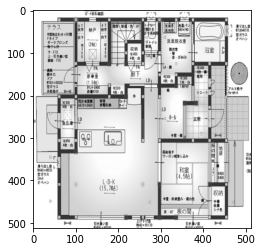

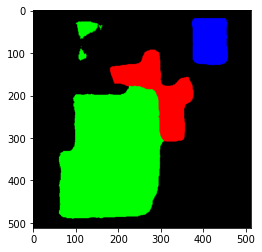

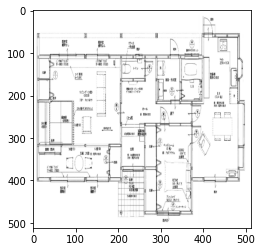

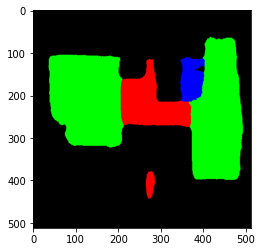

In [ ]:
size=512
background = [0,0,0]
LDK = [0,255,0]
Corridor = [255,0,0]
Bathroom = [0,0,255]
label_colours = np.array([background,Bathroom,LDK,Corridor])
def visualize(temp, plot=True):
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()
    for l in range(len(label_colours)):
        r[temp==l]=label_colours[l,0]
        g[temp==l]=label_colours[l,1]
        b[temp==l]=label_colours[l,2]
    rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
    rgb[:,:,0] = r#(r/255.0)#[:,:,0]
    rgb[:,:,1] = g#(g/255.0)#[:,:,1]
    rgb[:,:,2] = b#(b/255.0)#[:,:,2]
    if plot:
        plt.imshow(rgb)
    else:
        return rgb
count = min([10, len(output)])
for i in range(count):
  pred_class = np.argmax(output[i], axis=1).reshape((size,size))
  img_ret = visualize(pred_class, False)
  #img_ret = img_ret.astype(np.uint8)
  rgb = np.array(img_ret,np.uint8)
  img_rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)
  plt.figure(i * 2)
  plt.imshow(np.array(test_data[i], dtype=np.float32))
  plt.figure(i * 2 + 1)
  plt.imshow(img_rgb)
plt.show()

In [ ]:
output[1]

array([[0.25      , 0.25      , 0.25      , 0.25      ],
       [0.25      , 0.25      , 0.25      , 0.25      ],
       [0.25      , 0.25      , 0.25      , 0.25      ],
       ...,
       [0.96607757, 0.01130748, 0.01130748, 0.01130748],
       [0.96919125, 0.01026959, 0.01026959, 0.01026959],
       [0.9530368 , 0.01565441, 0.01565441, 0.01565441]], dtype=float32)